# ESN trials on reading ESNtutorial, Jaeger
Try to execute experiments in the paper :
- Jaeger, Herbert. (2002). Tutorial on training recurrent neural networks, covering BPPT, RTRL, EKF and the echo state network approach. GMD-Forschungszentrum Informationstechnik, 2002.. 5. 
- https://www.cse.iitk.ac.in/users/hk/cs671/201617/details/rnnTutorialJaeger.pdf

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from numpy import sin, cos, exp, tanh, pi, linspace, dot, sinh, cosh, arctanh
from numpy.random import normal
from numpy.linalg import eigvals, inv, norm, svd, pinv

from random import sample

from utils import unif, save_tex

## 6.1.1 ESN for sine wave generation
Generate sine wave 

In [4]:
# Parameters
D = 20 # Length of flush
L = 100 # Length of training
S = 100 # Length of simulation
r = 0.8 # Choose spectral radius
N = 20 # Reservoir size
noise = 0.000 # Variance of the random noise

# Activation functions
f_dr = lambda x: x #tanh(x) # Activation function inside DR
f_out = lambda x: x #tanh(x) # Activation function out
f_out_inv = lambda x: x #arctanh(x) # Inverse of activation function out

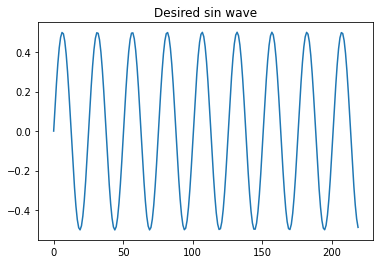

In [5]:
# Desired data
T = np.array([1/2*sin(n/4) for n in range(D + L + S)]) # Data
inv_T = np.array([f_out_inv(t) for t in T])
plt.plot(T);
plt.title("Desired sin wave");

In [6]:
# Neurons, randomly initalized
X = normal(size = N)

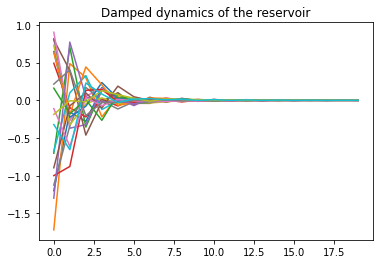

In [7]:
# Init reservoir weights
W = normal(size=(N, N)) # Weights inside reservoir, randomly initalized
W = W/max(abs(eigvals(W)))*r # Set spectral radius

# Show damped dynamics
M_void = np.zeros(shape=(D, N))
M_void[0] = X
for i in range(1, D):
    M_void[i] = f_dr(dot(W, M_void[i-1]))
plt.plot(M_void[:D,:]);
plt.title("Damped dynamics of the reservoir");

In [8]:
# Back weights
Wb = normal(size=N)
Wb = Wb/norm(Wb)

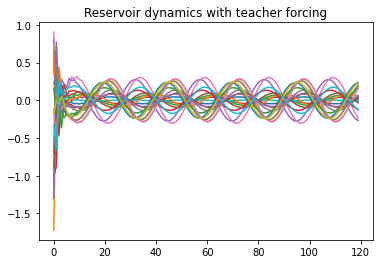

In [9]:
# Sample: 
M = np.zeros(shape=(D+L, N)) # Matrix of states
M[0] = X # init first state
for i in range(1, D+L):
    v = normal(scale=noise, size=N)
    M[i] = f_dr(dot(W, M[i-1]) + T[i-1]*Wb)  # reservoir signals + teacher forcing
plt.plot(M);
plt.title("Reservoir dynamics with teacher forcing");
import tikzplotlib
from os import system

save_tex("ztk", True)


In [10]:
# Training
M_tr = M[D:D+L,:] # Training part of data
M_ps = pinv(M_tr) # dot(inv(dot(M_tr.T,M_tr)), M_tr.T) (not the same as pinv, don't understand why) #pseudo inverse of M_tr
W_out = dot(pinv(M_tr), inv_T[D:D+L]) # Linear regression

In [11]:
# Simulation
M_S = np.zeros(shape=(D+L+S, N))
M_S[:D+L,:] = M
Y = np.zeros(D+L+S)
Y[:D+L] = f_out(dot(M,W_out))
for i in range(D+L,D+L+S):
    M_S[i] = f_dr(dot(W, M_S[i-1]) + Wb*Y[i-1])
    Y[i] = f_out(dot(M_S[i,:], W_out))

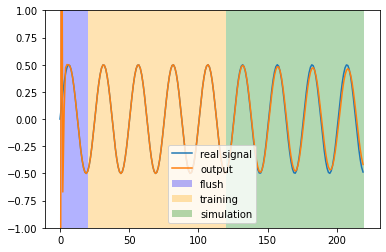

In [12]:
plt.plot(T)
plt.plot(Y)
plt.ylim(-1,1)
plt.axvspan(0, D, facecolor='blue', alpha=0.3)
plt.axvspan(D, D+L, facecolor='orange', alpha=0.3)
plt.axvspan(D+L, D+L+S, facecolor='green', alpha=0.3)

plt.legend(['real signal', 'output', 'flush', 'training', 'simulation'], loc='lower center');

## Notes
* Crucialy pay attention to indices details
* With a long simulation:
     * Rythm stays EXACTLY the same
     * Values exponentially deviates
* Performs less with sigmoid than with linear activation
* Even worse when adding noise

# 6.1.2 Tunewable sinewave generator
This time, generate sin wave with the desired frequency in input

In [13]:
# Parameters
D = 100 # Length of flush
L = 1200 # Length of training
S = 400 # Length of simulation
r = 0.8 # Choose spectral radius
N = 100 # Rerservoir size
var = 0.0001 # Sampling noise variance
density = 0.05 # Proportionaof non zero elements in weights

# Activation functions
f_dr = lambda x: tanh(x) # Activation function inside DR
f_out = lambda x: tanh(x) # Activation function out
f_out_inv = lambda x: arctanh(x) # Inverse of activation function out

ts = D+L+S # total size

Text(0.5, 1.0, 'Desired frequence')

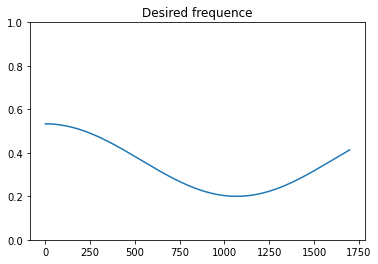

In [14]:
# Set the desired frequence along time
freq = np.array([(1 + cos(n/(ts/5)))/6 + 0.2 for  n in range(ts)]) # Desired frequence along time
plt.ylim(0,1)
plt.plot(freq);
plt.title("Desired frequence")

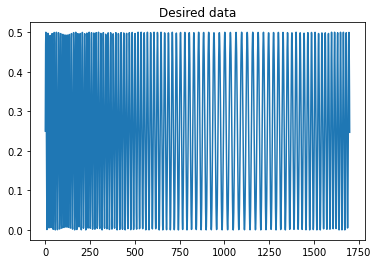

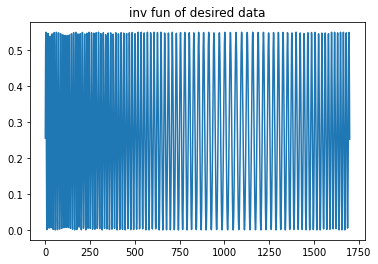

In [15]:
# Desired data
Td = np.array([1/4*(sin(sum(freq[:n])) + 1) for n,f in enumerate(freq)]) # Data

plt.figure(1)
plt.plot(Td);
plt.title("Desired data");

plt.figure(2)
T = np.array(list(map(f_out_inv, Td)))
plt.plot(T);
plt.title("inv fun of desired data");

In [16]:
# WEIGHTS
# input weights
W_in = normal(size=N)
W_in = W_in/norm(W_in)

# back
W_b = normal(size=N)
W_b = W_b/norm(W_b)

In [17]:
# Set sparse weights for DR
W = np.zeros(shape=(N,N)) # Init all to 0
Ne = int(density*N*N) # Number of edges
indices = np.array([ (i//N, i%N) for i in sample(range(N*N), Ne)]) # Selected non-zero elements
W[tuple(indices.T)] = normal(size=Ne) # Set all selected elements to random normal
W = W/max(abs(eigvals(W)))*r # Set spectral radius

In [18]:
# Sample
M = np.zeros(shape=(D+L, N)) # Set stat matrix
M[0,:] = normal(size=N) # initalise
for i in range(1,D+L):
    v = normal(scale=var, size = N) # Noise
    M[i,:] = f_dr(dot(W, M[i-1,:]) + W_in*freq[i-1] + W_b*T[i-1] + v)

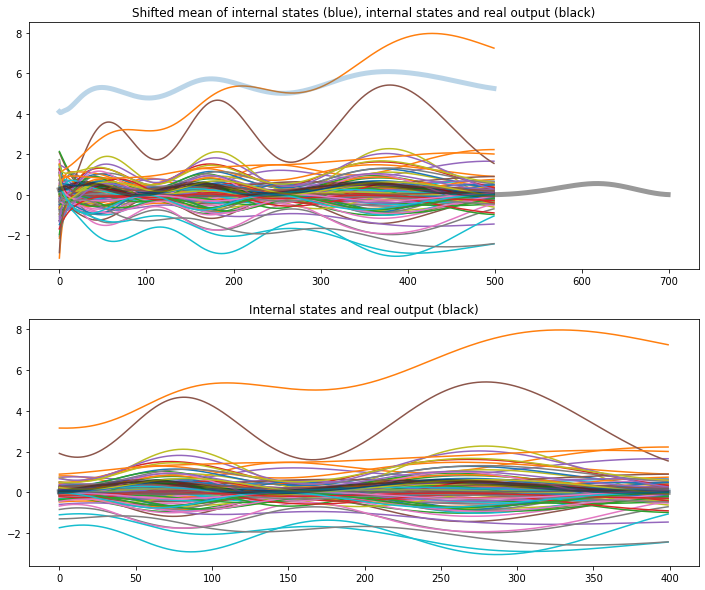

In [52]:
# Plot some infos
plt.figure(figsize=(12,10))
plt.subplot(2,1,1, title="Shifted mean of internal states (blue), internal states and real output (black)")
plt.plot(M);
plt.plot(M.mean(axis=1)*15+4, linewidth=5, alpha=0.3);
plt.plot(T, linewidth=5, color='black', alpha=0.4)
plt.subplot(2,1,2, title="Internal states and real output (black)")
plt.plot(M[D: D + L]);
plt.plot(M[D: D + L].mean(axis=1), linewidth=5, alpha=0.3);
plt.plot(T[D: D + L], linewidth=5, color='black', alpha=0.4)

In [21]:
# Train
M_tr = M[D:D+L]
W_out = dot(pinv(M_tr), T[D:D+L])

In [22]:
# Simulate
M_S = np.zeros(shape=(ts, N))
M_S[:D+L,:] = M
Y = np.zeros(ts)
Y[:D+L] = f_out(dot(M, W_out))
for i in range(D+L, D+L+S):
    M_S[i,:] = f_dr(dot(W, M_S[i-1,:]) + W_in*freq[i-1] + W_b*T[i-1])
    Y[i] = f_out(dot(W_out, M_S[i,:]))

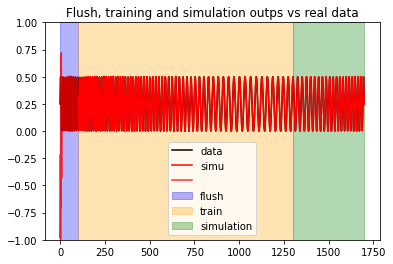

In [24]:
M_tr = M[D:D+L,:]

plt.plot(Td, color = 'black')
plt.plot(range(D,D+L+S) ,Y[D:], color = 'red')
plt.plot(Y[:D+1], alpha = 0.8, color = 'red')

plt.axvspan(0, D, -1, 1, color='blue', alpha = 0.3)
plt.axvspan(D, D+L, -1, 1,color='orange', alpha = 0.3)
plt.axvspan(D+L, D+L+S, -1, 1, color='green', alpha = 0.3)

plt.legend(['data','simu','','flush','train','simulation'], loc = 'lower center')
plt.ylim(-1,1)
plt.title("Flush, training and simulation outps vs real data");

Means: 
      - state: 0.051
      - output: 0.264
      - W_out*N: 121.322


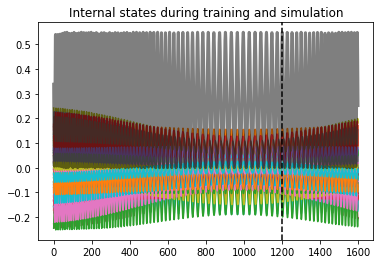

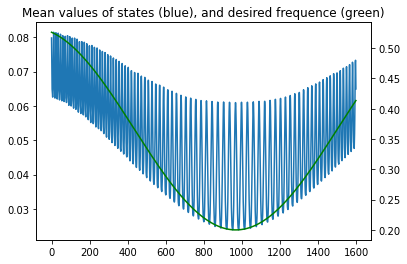

In [25]:
plt.figure()
plt.plot(M_S[D:]);
plt.plot(T[D:], linewidth=3, color='black', alpha=0.5)
plt.axvline(x=L, color='black', linestyle='--')
plt.title("Internal states during training and simulation")
plt.figure()
me = plt.subplot(1,1,1,title="Mean values of states (blue), and desired frequence (green)")
fr = me.twinx() 
me.plot(abs(M_S[D:]).mean(axis=1))
# me.plot(M[D:D+L].mean(axis=1))
fr.plot(freq[D:], color='green')
print(f"""Means: 
      - state: {abs(M[D:D+L]).mean():.3f}
      - output: {abs(T[D:D+L]).mean():.3f}
      - W_out*N: {abs(W_out).mean()*N:.3f}""")

## Remarques
* Added noise in sample and sometimes fits sometimes not:
    * Reduces amplitude over time
    * Juste diverge
* Finally worked, by correctly setting noise and f_out

# 7.1 Delay time
This ESN should output the input with a certain delay

In [26]:
from numpy.random import randint
from numpy import repeat, hstack

In [28]:
# Inputs: just a vector of randoms c or -c
c = 0.1
T = 300 # Training time
F = 100 # Flush out time
S = 100 # Simulation time
TT = T + F + S # Total time
U = (randint(0, 2, size=TT)*2 - 1)*c + normal(scale = c/10, size =TT) # Random input + small noise

K = [4, 8, 16, 20] # Different delays

In [30]:
# Output delayed inputs with 0 at the begining
d = lambda k: hstack((repeat(0, k), U[:-k]))
D = np.array([d(k) for k in K]).T

In [31]:
# Additional parameters
N = 20 # Number of neurons
f = lambda x: x # Activation function
r = 0.8 # Spectral radius
d = 0.15 # Density of weight matrix

In [34]:
# Init weights
W = unif(size=(N,N))
null_indices = [sample(range(N), N - int(d*N)), sample(range(N), N - int(d*N))]
W[tuple(null_indices)] = 0
W = W/max(abs(eigvals(W)))*r

W_in = unif(size=N) # DO NOT NORMALIZE

In [35]:
# Sample
M = np.zeros(shape=(TT, N))
M[0] = unif(size=N)
for i in range(1, TT):
    M[i] = f(dot(W, M[i - 1]) + dot(W_in, U[i - 1]))

In [36]:
# Train
W_out = dot(pinv(M[F : F + T,]), D[F : F + T,])

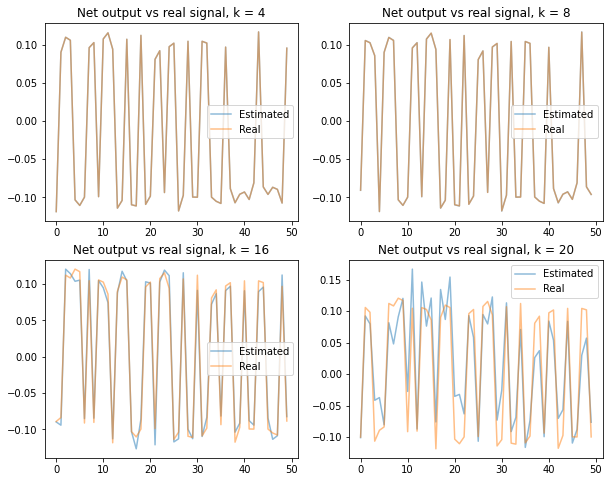

In [37]:
# Simulate
Y = dot(M, W_out)
tp = 50
fig, axes = plt.subplots(len(K)//2, 2, figsize = (10, 4*len(K)//2))
for i, ax in enumerate(axes.flat):
    ax.plot(Y[F + T : F + T + tp, i], alpha = 0.5)
    ax.plot(D[F + T : F + T + tp, i], alpha = 0.5)
    ax.set_title(f'Net output vs real signal, k = {K[i]}')
    ax.legend(['Estimated', 'Real'])

## Remarques
* Works well but DO NOT NORMALIZE W_in (why ? maybe input has too few impact then)

# 8. Spiking neurons long generator
In order to obtain long term dynamics, add a decaying term A which memorizes the last state of neuron.

In [38]:
# Parameters
D = 100 # Length of flush
L = 400# Length of training
S = 200 # Length of simulation
r = 0.8 # Choose spectral radius
N = 100 # Rerservoir size
var = 0.0001 # Sampling noise variance
density = 0.1 # Proportion of non zero elements in weights
max_decay = 0.4 # Max value of decay speed 

# Activation functions
f_dr = lambda x: tanh(x) # Activation function inside DR
f_out = lambda x: tanh(x) # Activation function out
f_out_inv = lambda x: arctanh(x) # Inverse of activation function out

ts = D+L+S # total size

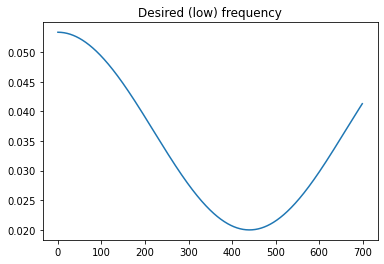

In [39]:
# Set the desired frequence along time
freq = 1/10*np.array([(1 + cos(n/(ts/5)))/6 + 0.2 for  n in range(ts)]) # Desired frequence along time

plt.plot(freq);
plt.title("Desired (low) frequency");

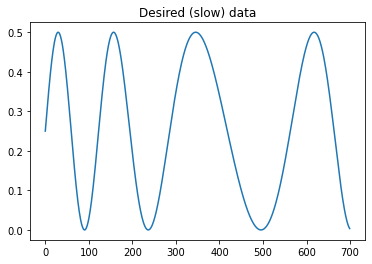

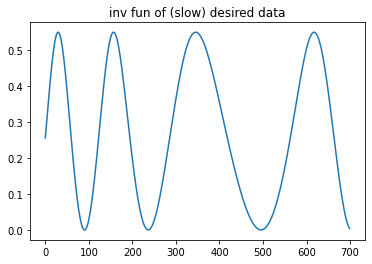

In [40]:
# Desired data
Td = np.array([1/4*(sin(sum(freq[:n])) + 1) for n,f in enumerate(freq)]) # Data

plt.figure(1)
plt.plot(Td);
plt.title("Desired (slow) data");

plt.figure(2)
T = np.array(list(map(f_out_inv, Td)))
plt.plot(T);
plt.title("inv fun of (slow) desired data");

In [41]:
# WEIGHTS
# input weights
W_in = normal(size=N)
W_in = W_in/norm(W_in)

# back
W_b = normal(size=N)
W_b = W_b/norm(W_b)

In [42]:
# DECAY
A = np.zeros(shape=(N,N))
A[(range(N),range(N))] = unif(0, max_decay, N)
R = np.identity(N) - A # R is the persistence

In [43]:
# Set sparse weights for DR
W = np.zeros(shape=(N,N)) # Init all to 0
Ne = int(density*N*N) # Number of edges
indices = np.array([ (i//N, i%N) for i in sample(range(N*N), Ne)]) # Selected non-zero elements
W[tuple(indices.T)] = normal(size=Ne) # Set all selected elements to random normal
W = W/max(abs(eigvals(W)))*r # Set spectral radius

In [44]:
# Sample
M = np.zeros(shape=(D+L, N)) # Set stat matrix
M[0,:] = normal(size=N) # initalise
for i in range(1,D+L):
    v = normal(scale=var, size = N) # Noise
    M[i,:] = dot(R, M[i-1,:]) + f_dr(dot(dot(A,W), M[i-1,:]) + W_in*freq[i-1] + W_b*T[i-1] + v)

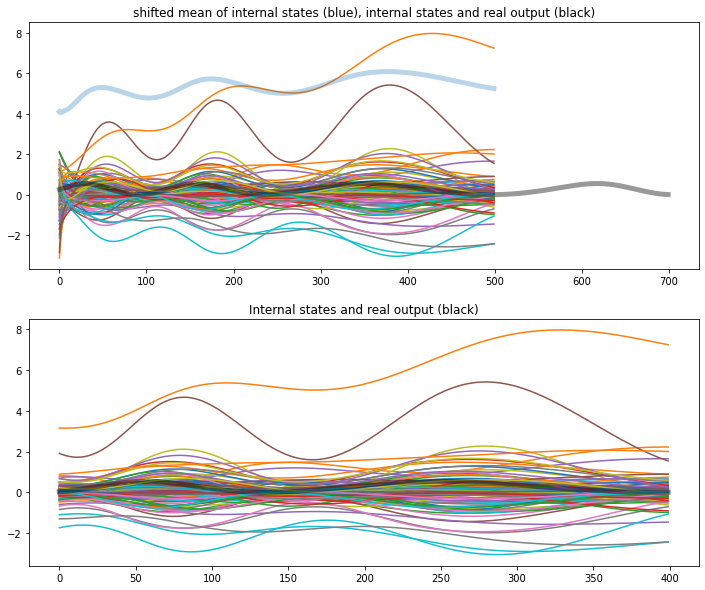

In [51]:
# Plot some infos
plt.figure(figsize=(12,10))
plt.subplot(2,1,1, title="shifted mean of internal states (blue), internal states and real output (black)")
plt.plot(M);
plt.plot(M.mean(axis=1)*15+4, linewidth=5, alpha=0.3);
plt.plot(T, linewidth=5, color='black', alpha=0.4)

plt.subplot(2,1,2, title="Internal states and real output (black)")
plt.plot(M[D: D + L]);
plt.plot(M[D: D + L].mean(axis=1), linewidth=5, alpha=0.3);
plt.plot(T[D: D + L], linewidth=5, color='black', alpha=0.4)

In [46]:
# Train
M_tr = M[D:D+L]
W_out = dot(pinv(M_tr), T[D:D+L])

In [47]:
# Simulate
M_S = np.zeros(shape=(ts, N))
M_S[:D+L,:] = M
Y = np.zeros(ts)
Y[:D+L] = f_out(dot(M, W_out))
for i in range(D+L, D+L+S):
    M_S[i,:] = dot(R, M_S[i-1,:]) + f_dr(dot(dot(A,W), M_S[i-1,:]) + W_in*freq[i-1] + W_b*T[i-1])
    Y[i] = f_out(dot(W_out, M_S[i,:]))

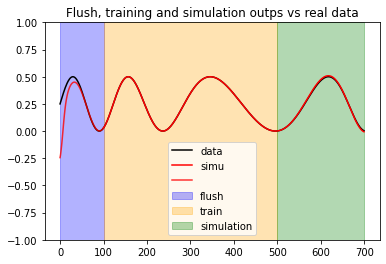

In [53]:
M_tr = M[D:D+L,:]

plt.plot(Td, color = 'black')
plt.plot(range(D,D+L+S) ,Y[D:], color = 'red')
plt.plot(Y[:D+1], alpha = 0.8, color = 'red')

plt.axvspan(0, D, -1, 1, color='blue', alpha = 0.3)
plt.axvspan(D, D+L, -1, 1,color='orange', alpha = 0.3)
plt.axvspan(D+L, D+L+S, -1, 1, color='green', alpha = 0.3)

plt.legend(['data','simu','','flush','train','simulation'], loc = 'lower center')
plt.ylim(-1,1);
plt.title("Flush, training and simulation outps vs real data");

Means: 
      - state: 0.541
      - output: 0.270
      - W_out*N: 8.659


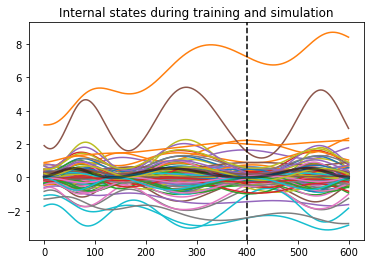

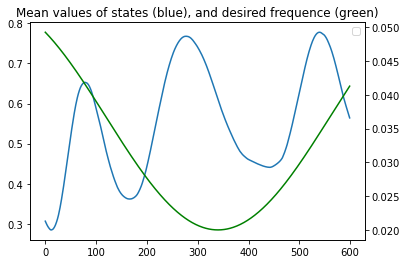

In [54]:
plt.figure()
plt.plot(M_S[D:]);
plt.plot(T[D:], linewidth=3, color='black', alpha=0.5)
plt.title("internal state")
plt.axvline(x=L, color='black', linestyle='--')
plt.title("Internal states during training and simulation")

plt.figure()
me = plt.subplot(1,1,1,title="Mean values of states (blue), and desired frequence (green)")
fr = me.twinx() 
me.plot(abs(M_S[D:]).mean(axis=1))
# me.plot(M[D:D+L].mean(axis=1))
fr.plot(freq[D:], color='green')
plt.legend("")
print(f"""Means: 
      - state: {abs(M[D:D+L]).mean():.3f}
      - output: {abs(T[D:D+L]).mean():.3f}
      - W_out*N: {abs(W_out).mean()*N:.3f}""")

Notes: ok, worked well